<a id='Top'></a>
# Deep Neural Networks - Part 2: Recurrent and HPO

### Table of Contents:

1. Introduction:
    + [Introduction and Objectives](#Introduction)
    + [Data overview and Pre-processing](#Data)


2. Methodology:
    + [A Common-sense Baseline and Simple Model](#Simple)
    + [A Larger HyperModel and Tuning](#HyperModel)
    + [Overfitting and Regularisation](#Regular)


3. Results:
    + [Test Set Evaluation](#Evaluation)
    + [Ranking Performance](#Rank)


4. Conclusions:
    + [Conclusions](#Conclusions)
    + [References](#References)
    + [Appendix](#Appendix)

<a id='Introduction'></a>
### Introduction and Objectives
[Back to top](#Top)

This investigation will follow the Deep Learning Workflow to develop deep recurrent neural networks tasked with predicting the usefulness of a given input sentence sampled from a large collection of online product reviews and human-tagged for utility in purchase decision-making. These data are published under a [CDLA-Sharing license](https://cdla.dev/sharing-1-0/), and are available as part of [AWS Open Data collection](https://registry.opendata.aws/helpful-sentences-from-reviews/). In a 2021 publication, Gazmu et. al., detail the process of data collection, and various regression models predicting helpfulness as part of a larger system that integrates identification of sentences that are representative to produce succinct reviews usable in space-limited contexts (namely, mobile and voice-mediated devices).

A useful model in this context will be capable of reliably identifying sentences with high helpfulness for a particular product in order to facilitate presenting a screen-space limited user with the most useful information. We assume that what determines usefulness of a review sentence will vary between products, possibly depending on their use or intended user, and so hypothesize that a network will benefit from information about the what kind of product is under consideration. Explicit product differentiation, though feasible, would likely prevent generalizability to novel products as well as within products of similar types. To address this without generalizable product category data, we propose to add respective product names as a second input to our model. A reproducible experiment setup is presented here in the form of a functionally defined hypermodel representing a deep recurrent neural network that can be reconfigured for parameterized hyperparamer optimization in either a sequential mode with a single input or as a multi-input network which considers a product title in addition to a respective sentence vector. Our evaluation procedure will compare the performance of these models in terms of test split mean absolute accuracy as well as performance in a product-segmented ranking task. 

A baseline is defined with a regressor applied to Term-Frequency Inverse Document Frequency vectors. A simple network consisting of learned embeddings and a single Long Short-Term Memory layer is trained to achieve better results than the baseline. A search space for a larger model is then defined as a functional hypermodel and hyperparamter optimization is performed on single-input sequential and multi-input versions. The best performing models are then explored in more depth for signs of overfit and made more robust with regularization. The results are then applied to test split data and the results are discussed.

Tensorflow Keras and Keras Tuner (O'Malley, et. al. 2019) are employed in building and optimizing networks. Implementations of Stochastic Gradient Descent regressor, tf-idf vectorization, and MSE/MAE scoring are utilized from the Sklearn package (Pedregosa, et. al. 2011). A Snowball stemmer is used in text preprocessing for the baseline model (Porter, 1980). The Kendall's Tau statistic is utilized in analysis of the final models' ranking performances (Kendall, 1938).

In [1]:
import os # confirming/rebuilding dir structure
import re # text cleaning steps
import string # text cleaning steps
from typing import List, Optional, Any, Generator # typehints
import datetime
import keras_tuner as kt # hyperparameter tuning framework
import tensorflow as tf
import sys

from tensorflow.keras.preprocessing.text import Tokenizer # convenience namespaces
from tensorflow.keras.preprocessing.sequence import pad_sequences # "
from tensorflow.keras import layers # "
from tensorflow.keras import regularizers # "

import jsonlines # parsing original data
import nltk # stemming and stopword functionality in text processing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats # for our ranking evaluation
from statistics import mean
from sklearn.feature_extraction.text import TfidfVectorizer # vectorizing for baseline
from sklearn.linear_model import SGDRegressor # modeling for baseline
from sklearn.metrics import mean_absolute_error, mean_squared_error # accuracy scoring for baseline

In [2]:
# ensure we have nltk stopwords and set a random seed
nltk.download("stopwords") # for text preprocessing
tf.random.set_seed(24)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sheplecjs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Tensorflow version used for this analysis
print(f"python: {sys.version}\ntensorflow: {tf.__version__}")

python: 3.8.12 (default, Sep 24 2021, 12:36:12) 
[Clang 13.0.0 (clang-1300.0.29.3)]
tensorflow: 2.8.0


<a id='Data'></a>
### Data Overview and Pre-processing
[Back to top](#Top)

*Code is provided to parse, and load data into dataframes. After previewing the data, we provide a customizable text processing function for use in a non-neural network baseline model with tf-idf vectors. After this initial preprocessing is applied to the appropriate text data in training and testing datasets, we briefly explore the dimensionality of word tokens in our training dataset so that we can make informed decisions about sequence length and maximum token numbers.*

In [4]:
# read these jsonlines files into train and test arrays
raw_train = []
raw_test = []

cwd = os.getcwd()

with jsonlines.open(cwd + "/data/train.json") as reader:
    for obj in reader:
        raw_train.append(obj)

with jsonlines.open(cwd + "/data/test.json") as reader:
    for obj in reader:
        raw_test.append(obj)

In [5]:
# read to dataframes and preview
df = pd.DataFrame(raw_train)
df_test = pd.DataFrame(raw_test)

df.head(n=8)

,asin,sentence,helpful,main_image_url,product_title
0,B000AO3L84,this flash is a superb value.,1.70,http://ecx.images-amazon.com/images/I/41XAEKR9...,Canon 430EX Speedlite Flash for Canon EOS SLR ...
1,B001SEQPGK,The pictures were not sharp at all.,1.30,http://ecx.images-amazon.com/images/I/71KLvmtc...,Sony Cyber-shot DSC-W290 12 MP Digital Camera ...
2,0553386697,A very good resource for parents.,1.90,http://ecx.images-amazon.com/images/I/81HdbmkR...,The Whole-Brain Child: 12 Revolutionary Strate...
3,B006SUWZH2,"We have it in a child's room, and will be swit...",0.25,http://ecx.images-amazon.com/images/I/61A2WQOL...,Memorex Portable CD Boombox with AM FM Radio
4,B000W7F5SS,Again the makers are too lazy to bring in the ...,0.90,http://ecx.images-amazon.com/images/I/91E7TPDb...,Harry Potter and the Order of the Phoenix (Wid...
5,B000AO3L84,This flash is a great value for the money.,2.00,http://ecx.images-amazon.com/images/I/41XAEKR9...,Canon 430EX Speedlite Flash for Canon EOS SLR ...
6,B00081NX5U,"So I've had these speakers for three days now,...",0.73,http://ecx.images-amazon.com/images/I/51GQZT32...,iPod Detachable Receiver 7
7,B00000F1D3,"they're cd's or tape's forget about the ""spice...",0.90,http://ecx.images-amazon.com/images/I/41H0Y95G...,Believe


In [6]:
# a custom processing function for text preprocessing

def process_text(text: str,
                 stemming: bool = True,
                 clean_numeric: bool = True,
                 clean_punctuation: bool = True,
                 clean_stopwords: bool = True,
                 additional_stops: Optional[List[str]] = None,
                 lowercase: bool = True) -> Generator:
    
    # lower text case
    if lowercase:
        text = text.lower()
    
    # remove punctuation
    if clean_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove numbers
    if clean_numeric:
        text = re.sub(r"[0-9]", "", str(text))
    
    # define stopwords as set
    stop_words = set(nltk.corpus.stopwords.words("english"))
    
    # append additional stopwords if specified
    if additional_stops:
        [stop_words.append(w) for w in additional_stops]
    
    text = text.split()
    
    # remove stopwords
    if clean_stopwords:
        text = [w for w in text if w not in stop_words]
    
    # stem results
    if stemming:
        stemmer = nltk.stem.snowball.SnowballStemmer("english")
        text = [stemmer.stem(w) for w in text]
    
    result = [w for w in text]

    return result

In [7]:
# a function for profiling the sentence data dimensionality

def text_characteristics(df: pd.DataFrame, column_name: str) -> int:
    
    # count and describe sentence length
    df[column_name + "_word_count"] = df[column_name].str.split().str.len()
    useful_length = int(df[column_name + "_word_count"].describe(percentiles=[0.95,]).loc["95%"])
    
    # count unique words in our training data
    word_counter = {}

    for s in df[column_name]:
        clean = s.translate(str.maketrans("", "", string.punctuation))
        for w in clean.split():
            try:
                word_counter[w.lower()] +=1
            except KeyError:
                word_counter[w.lower()] = 1

    # seriously consider only those tokens that occur more than twice
    useful_tokens = len([v for v in word_counter.values() if int(v) > 1])
    
    print(f"95% of sentences are of length {useful_length} or lower.\nOnly {useful_tokens} words are used more than once.")
    
    return useful_length, useful_tokens

In [8]:
length_sentences, tokens_sentences = text_characteristics(df, "sentence")

95% of sentences are of length 30 or lower.
Only 8216 words are used more than once.


In [9]:
length_titles, tokens_titles = text_characteristics(df, "product_title")

95% of sentences are of length 18 or lower.
Only 624 words are used more than once.


#### Notes:

*The usefulness of tokens that only appear once in our training data is spurious. Additionally, and especially because we will be using bidirectional layers, limiting the sequence length may help our training proceed efficiently, so we will save these metrics and pass them to our TextVectorization layers.*

In [10]:
# convenience labels

train_data = df[["sentence", "product_title"]]
train_targets = df["helpful"].to_numpy()

test_data = df_test[["sentence", "product_title"]]
test_targets = df_test["helpful"].to_numpy()

# to facilitate ranking-based scoring of final model performance 
test_by_category =  df_test[["asin", "sentence", "product_title", "helpful"]]

<a id='Simple'></a>
### A Common-sense Baseline and Simple Model
[Back to top](#Top)

*To establish an initial baseline, we will produce a minimally performant non-neural network model. Specifically, we utilize a Stochastic Gradient Descent regressor applied to Term Frequency Inverse Document Frequency vectors. We then create a simple recurrent network which beats it's performance in terms of Mean Absolute Error on the test set.*

In [11]:
# instantiate vectorizers
TF = TfidfVectorizer(max_features=tokens_sentences, analyzer=process_text)

train_tfidf_features = TF.fit_transform([doc for doc in train_data["sentence"]])

test_tfidf_features = TF.transform([doc for doc in test_data["sentence"]])

# instantiate regressor, fit, and predict
sgd = SGDRegressor(random_state=34)
baseline_model = sgd.fit(train_tfidf_features, train_targets)
base_prediction = sgd.predict(test_tfidf_features)

# calculate MAE scores for prediction
base_mse, base_mae = mean_squared_error(test_targets, base_prediction), mean_absolute_error(test_targets, base_prediction)

print(base_mse, base_mae)

0.1228345677771492 0.28386842471037527


##### Before defining a simple model, we'll configure callbacks and vectorization layers.

+ **Learning Rate Reducer**: *If validation loss does not improve over 3 epochs, the learning rate is decreased for the next epoch by a factor of 10*

+ **Early Stopping**: *If validation loss does not improve over 5 epochs, training will stop.*

In [12]:
# configuration of callbacks for saving best and learning rate reducer

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    mode="min",
    cooldown=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

cbs = [lr_reducer, early_stop]


# configuration and adaptation of text vectorization layer

sentence_vectorizer = layers.TextVectorization(standardize=None, 
                                               split="whitespace", 
                                               output_mode="int", 
                                               output_sequence_length=length_sentences,
                                               max_tokens=tokens_sentences)


# create a tf.data object with our input text
sentence_text = tf.data.Dataset.from_tensor_slices(train_data["sentence"]).batch(128)

# adapt the sentence vectorizer to the vocabulary in training data
sentence_vectorizer.adapt(sentence_text)

2022-03-27 09:11:27.657305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# code for creating embedding matrix from embedding file adapted from Chollet, 2017 pg.190 - 191

def embedding_matrix(path_to_embedding: str, 
                     vectorizer: tf.keras.layers.TextVectorization, 
                     dim: int) -> np.ndarray:
    em_idx = {}
    with open(path_to_embedding) as p:
        for line in p:
            word, coefficients = line.split(maxsplit=1)
            coefficients = np.fromstring(coefficients, "f", sep=" ")
            em_idx[word] = coefficients
            
    vocab = vectorizer.get_vocabulary()
    wrd_idx = dict(zip(vocab, range(len(vocab))))
    
    tokens_num = len(vocab) + 2
    embedding_dim = dim
    
    em_matrix = np.zeros((tokens_num, embedding_dim))
    for word, i in wrd_idx.items():
        try:
            em_vec = em_idx[word]
            em_matrix[i] = em_vec
        except KeyError:
            continue
            
    return em_matrix

In [14]:
sentence_matrix = embedding_matrix(f"glove.6B.100d.txt", sentence_vectorizer, 100)

sentence_embed = layers.Embedding(
    len(sentence_vectorizer.get_vocabulary()) + 2,
    100,
    embeddings_initializer=tf.keras.initializers.Constant(sentence_matrix),
    trainable=False,
)

In [15]:
basic_model = tf.keras.Sequential(
    [
        sentence_vectorizer,
        sentence_embed,
        layers.LSTM(8),
        layers.Dense(1)
    ]
)

basic_model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 100)           821800    
                                                                 
 lstm (LSTM)                 (None, 8)                 3488      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 825,297
Trainable params: 3,497
Non-trainable params: 821,800
_________________________________________________________________


*Our simple network consists of an embedding layer, a single Long-Short term memory layer, and a final dense layer suitable for a regression task. Word embedding relies on [pre-trained word embeddings](https://nlp.stanford.edu/projects/glove/) using the GloVe algorithm and published under the [Public Domain and Dedication License](https://opendatacommons.org/licenses/pddl/) (Pennington, et. al. 2014). Code for creating embedding matrix from embedding file is adapted from Chollet, 2017 pg.190 - 191.*

![basic network](basic_model.png)
*see [Appendix](#Appendix) for graph-generating code*

In [16]:
history = basic_model.fit(train_data["sentence"], 
                          train_targets, 
                          epochs=10, 
                          validation_split=0.15, 
                          callbacks=cbs)

basic_scores = basic_model.evaluate(test_data["sentence"], test_targets, verbose=1)
print(f"{basic_scores}")

Epoch 1/10
532/532 [==============================] - 6s 8ms/step - loss: 0.2488 - mae: 0.3877 - val_loss: 0.1192 - val_mae: 0.2791 - lr: 0.0010
Epoch 2/10
532/532 [==============================] - 4s 7ms/step - loss: 0.1334 - mae: 0.2964 - val_loss: 0.1023 - val_mae: 0.2541 - lr: 0.0010
Epoch 3/10
532/532 [==============================] - 4s 7ms/step - loss: 0.1226 - mae: 0.2826 - val_loss: 0.1027 - val_mae: 0.2543 - lr: 0.0010
Epoch 4/10
532/532 [==============================] - 5s 9ms/step - loss: 0.1182 - mae: 0.2763 - val_loss: 0.0981 - val_mae: 0.2483 - lr: 0.0010
Epoch 5/10
532/532 [==============================] - 4s 8ms/step - loss: 0.1138 - mae: 0.2703 - val_loss: 0.0951 - val_mae: 0.2452 - lr: 0.0010
Epoch 6/10
532/532 [==============================] - 4s 7ms/step - loss: 0.1109 - mae: 0.2664 - val_loss: 0.0967 - val_mae: 0.2467 - lr: 0.0010
Epoch 7/10
532/532 [==============================] - 4s 8ms/step - loss: 0.1090 - mae: 0.2634 - val_loss: 0.0927 - val_mae: 0.240

<a id='HyperModel'></a>
### A Larger HyperModel and Tuning
[Back to top](#Top)

*To produce a larger network and facilitate an experiment that will test our hypothesis that product information in the form of product title integrated using a multi-input RNN, a hypermodel is defined by subclassing and customizing the HyperModel class provided in the Keras-Tuner module (O'Malley, et. al. 2019). This hypermodel will define a search space for a single-input sequential and multi-input RNNs using Long-Short Term Memory layers. Optimal hyperparameter search will then be performed with both architectures. In addition to learning rate reducer and early stopping callbacks used with the simple model, we will also utilize tensorboard to facilitate monitoring of hyperparameter search.*

*Tunable parameters include, number of LSTM layers, nodes of layers, direction of layers, final dense layer, final dense layer nodes, and sequential or multi-input configuration. These parameters are tunable in both branches if the model is multi-input. Learning rate is adjusted if validation loss does not improve according to parameters of a learning rate reducing callback function. Hyperparameter tuning is performed for 25 trials for each single-input and multi-input configuration.*

*Below are graphs of the default proposed networks:*

Default Sequential | Default Multi-Input
:-: | :-:
![best sequential](sequential_model.png) | ![best multi](multi_input_model.png)
*see [Appendix](#Appendix) for graph-generating code*

In [17]:
class LstmHyperModel(kt.HyperModel):
    """A hypermodel object representing the search space for a network based on stacked LSTM layers.
    Includes the following tunable parameters:
    
    3-6 LSTM layers
        80-120 nodes (6 steps)
        Normal or bidirectional (2 steps)
        
    1 LSTM layer
        80-120 nodes (6 steps)
    
    None | Dense layer
        None | 4-24 nodes (7 steps)
        
    Sequential | Multi-input
        None | 1-3 LSTM layers
        None |     80-120 nodes (6 steps)
        None | 1 LSTM layer
        None | None | Dense
        None | None | 4-24 nodes (6 steps)
        
    """
    def __init__(
        self: kt.HyperModel,
        title_vectorizer: tf.keras.layers.TextVectorization,
        sentence_vectorizer: tf.keras.layers.TextVectorization,
        default_type: str,
        sentence_embedding_matrix: Optional[np.ndarray] = None,
        title_embedding_matrix: Optional[np.ndarray] = None,
        sentence_regularizer: Optional[Any] = None,
        title_regularizer: Optional[Any] = None
    ):

        # add the text vectorizers to the HM object
        self.title_vectorizer = title_vectorizer
        self.sentence_vectorizer = sentence_vectorizer

        # to facilitate variable default type for visualisations
        self.default_type = default_type

        # pre-trained embeddings to use if we have them
        self.sentence_embed = sentence_embedding_matrix
        self.title_embed = title_embedding_matrix
        
        # add regularizers to model
        self.sentence_regularizer = sentence_regularizer
        self.title_regularizer = title_regularizer

    def build(self, hp: kt.engine.hyperparameters.HyperParameters):

        # grab our token numbers to pass to the embedding layers
        sentence_tokens = self.sentence_vectorizer._max_tokens

        sentence_input = tf.keras.Input(
            shape=(1,), dtype=tf.string, name="sentence input"
        )

        # embed sentence and tune vector dimension
        sentence_features = self.sentence_vectorizer(sentence_input)

        # if we've defined pre-trained embeddings use them, otherwise connect a layer to learn embeddings
        if self.sentence_embed:
            sentence_features = self.sentence_embed(sentence_features)
        else:
            sentence_features = layers.Embedding(
                sentence_tokens,
                hp.Int(
                    "sentence dims", min_value=80, max_value=120, step=8, default=80
                ),
            )(sentence_features)

        for l in range(hp.Int("lstm layers", 3, 6, default=3)):

            lstm_layer = layers.LSTM(
                hp.Int(
                    f"sent nodes {l}", min_value=80, max_value=120, step=8, default=80
                ),
                return_sequences=True,
            )

            # tune bidirectionality of layer(s)
            if (
                hp.Choice(
                    "dir " + str(l), ["normal", "bidirectional"], default="normal"
                )
                == "bidirectional"
            ):
                lstm_layer = layers.Bidirectional(lstm_layer)

            # reduce sequence of embedded sentence words
            sentence_features = lstm_layer(sentence_features)

        # final lstm layer omitting sequence return
        final = layers.LSTM(
            hp.Int("sent nodes final", min_value=80, max_value=120, step=8, default=80),
            kernel_regularizer=self.sentence_regularizer,
            return_sequences=False,
        )(sentence_features)

        # possible last dense layer in sentence branch
        last_dense = hp.Choice("last dense", ["dense", "none"], default="none")
        if last_dense == "dense":
            with hp.conditional_scope("last dense", ["dense"]):
                final = layers.Dense(
                    hp.Int(
                        "final dense nodes",
                        min_value=4,
                        max_value=24,
                        step=4,
                        default=24,
                    )
                )(final)

        # define input
        input_names = [
            sentence_input,
        ]

        # define title input branch if specified
        model_type = hp.Choice(
            "model_type", ["sequential", "multi_input"], default=self.default_type
        )
        if model_type == "multi_input":
            with hp.conditional_scope("model_type", ["multi_input"]):

                title_tokens = self.title_vectorizer._max_tokens
                title_input = tf.keras.Input(
                    shape=(1,), dtype=tf.string, name="title input"
                )

                # add input for final model params
                input_names.append(title_input)

                title_features = self.title_vectorizer(title_input)

                if self.title_embed:
                    title_features = self.title_embed(title_features)
                else:
                    title_features = layers.Embedding(
                        title_tokens,
                        hp.Int(
                            "title dims", min_value=8, max_value=64, default=16, step=8
                        ),
                    )(title_features)

                for t in range(hp.Int("title layers", 1, 3, default=1)):

                    title_features = layers.LSTM(
                        hp.Int(
                            f"title nodes {t}",
                            min_value=80,
                            max_value=120,
                            step=8,
                            default=80,
                        ),
                        return_sequences=True,
                    )(title_features)

                title_features = layers.LSTM(
                    hp.Int(
                        "last title layer",
                        min_value=10,
                        max_value=20,
                        step=2,
                        default=10,
                    ),
                kernel_regularizer=self.title_regularizer,
                    return_sequences=False,
                )(title_features)

                # possible last dense layer for title bracnch
                last_title_dense = hp.Choice(
                    "last title dense", ["dense", "none"], default="none"
                )
                if last_title_dense == "dense":
                    with hp.conditional_scope("last title dense", ["dense"]):
                        title_features = layers.Dense(
                            hp.Int(
                                "title dense",
                                min_value=4,
                                max_value=24,
                                step=4,
                                default=24,
                            )
                        )(title_features)

                # merge features
                final = layers.concatenate([title_features, final])

        # regression task final layer
        useful_pred = layers.Dense(1, name="helpful_predict")(final)

        model = tf.keras.Model(
            inputs=input_names,
            outputs=useful_pred,
        )

        model.compile(
            optimizer="Adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"]
        )

        return model

In [18]:
# a seperate layer for vectorizing titles

title_vectorizer = layers.TextVectorization(standardize=None,
                                            split="whitespace",
                                            output_mode="int",
                                            output_sequence_length=length_titles,
                                            max_tokens=tokens_titles,
                                            name="title_vec")

title_text = tf.data.Dataset.from_tensor_slices(train_data["product_title"]).batch(128)

title_vectorizer.adapt(title_text)

In [19]:
# experiment definitions

MAX_TRIALS = 25
SEED = 55
SENTENCE_DIMS = 300
TITLE_DIMS = 300

# define and load embeddings
sentence_matrix = embedding_matrix(f"glove.6B.{SENTENCE_DIMS}d.txt", sentence_vectorizer, SENTENCE_DIMS)
title_matrix = embedding_matrix(f"glove.6B.{TITLE_DIMS}d.txt", title_vectorizer, TITLE_DIMS)

sentence_embed = layers.Embedding(
    len(sentence_vectorizer.get_vocabulary()) + 2,
    SENTENCE_DIMS,
    embeddings_initializer=tf.keras.initializers.Constant(sentence_matrix),
    trainable=False,
)

title_embed = layers.Embedding(
    len(title_vectorizer.get_vocabulary()) + 2,
    TITLE_DIMS,
    embeddings_initializer=tf.keras.initializers.Constant(title_matrix),
    trainable=False,
)

# instantiating a hyper parameter object
hp_seq = kt.HyperParameters()

# fixing model type to sequential
hp_seq.Fixed("model_type", value="sequential")

# defining our tuner
tuner_sequential = kt.BayesianOptimization(
    hypermodel=LstmHyperModel(title_vectorizer, 
                              sentence_vectorizer, 
                              "sequential",
                              sentence_embed),
    hyperparameters=hp_seq,
    seed=SEED,
    tune_new_entries=True,
    objective="val_loss",
    max_trials=MAX_TRIALS,
    overwrite=True,
    project_name="tuning_sequential",
)


hp_multi = kt.HyperParameters()

hp_multi.Fixed("model_type", value="multi_input")

tuner_multi_input = kt.BayesianOptimization(
    hypermodel=LstmHyperModel(title_vectorizer, 
                              sentence_vectorizer, 
                              "multi_input",
                              sentence_embed,
                              title_embed),
    hyperparameters=hp_multi,
    seed=SEED,
    tune_new_entries=True,
    objective="val_loss",
    max_trials=MAX_TRIALS,
    overwrite=True,
    project_name="tuning_multi",
)

In [20]:
# redefine callbacks with tensorboard for monitoring

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    mode="min",
    cooldown=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

# run parameter
log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    write_graph=True,
)

cbs = [lr_reducer, early_stop, tensorboard]

In [21]:
# multi-input training data convenience

multi_input_train_data = {"sentence input": train_data["sentence"], 
                          "title input": train_data["product_title"]}

In [22]:
# sequential search

tuner_sequential.search(multi_input_train_data, 
                        train_targets,
                        validation_split=0.15,
                        epochs=100, # with early stopping callback this is an unlikely limit
                        callbacks=cbs,
                        use_multiprocessing=True)

Trial 25 Complete [00h 06m 00s]
val_loss: 0.08657179772853851

Best val_loss So Far: 0.0840306207537651
Total elapsed time: 02h 46m 17s
INFO:tensorflow:Oracle triggered exit


In [23]:
# multi-input search

tuner_multi_input.search(multi_input_train_data, 
                         train_targets,
                         validation_split=0.15,
                         epochs=100,
                         callbacks=cbs,
                         use_multiprocessing=True)

Trial 25 Complete [00h 09m 22s]
val_loss: 0.0848553478717804

Best val_loss So Far: 0.08384261280298233
Total elapsed time: 04h 43m 07s
INFO:tensorflow:Oracle triggered exit


<a id='Regular'></a>
### Overfitting and Regularisation
[Back to top](#Top)

*Because we have employed a callback ending training when validation loss stopped improving, we may have failed to fit our models sufficiently. In order to confirm that we are training for the optimal number of epochs for our best models and avoiding overfit, we will retrain on a large number of epochs, visualize validation performance to identify where overfitting begins. We will utilize a learning rate reduction callback as well to ensure a high learning rate is preventing access to the lowest validation loss.*

**Code for calculating and visualising validation MSE/MAE over a range of epochs is adapted from Chollet 2018 (pg. 89-90).**

In [24]:
# code for visualizing validation performance over a number of epochs

def optimal_epochs(
    history: Any,
    start: int=1, 
    x_annotate_offset: float=1.0,
    y_annotate_offset: float=0.00003
    ) -> None:
    
    """Gives us the historical MSE and MAE useful for checking for when
    overfitting occurs, smooths MAE data as specified, graphs lowpoints
    into subplots.

    Args:

        history (kt.model.history): A keras model history to visualize for overfit.

        smoothing_factor (float): Factor to apply to MAE smoothing function.
        Defaults to 0.9.
        
        start (int): Start epoch for smoothed MAE plot. Defaults to 1.
        
        y_annotate_offset (float, optional): Offset for annotation label. Defaults tp 0.00003.

    Returns:
        tuple: Collection of validation mean absolute error and validation loss histories.
    """

    mae_history = history.history["val_mae"]
    mse_history = history.history["val_loss"]
    
    fitted = min(mse_history)
    fitted_x = mse_history.index(fitted) + start
    
    lowest = min(mae_history)
    lowest_x = mae_history.index(lowest) + start
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    
    ax[0].plot(range(start, len(mse_history) + start), mse_history, color="tab:orange")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Validation MSE")
    ax[0].plot(fitted_x, fitted, ls="", marker="o", label="points", color="tab:red")
    ax[0].annotate(
        "%s" % (fitted_x), (fitted_x + x_annotate_offset, fitted - y_annotate_offset), xycoords="data", color="tab:red"
    )
    ax[0].set_title("Validation Mean Squared Error by Epoch")
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    ax[1].plot(
        range(start, len(mae_history) + start), mae_history, color="tab:blue"
    )

    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Validation MAE")
    ax[1].plot(lowest_x, lowest, ls="", marker="o", label="points", color="tab:red")
    ax[1].annotate(
        "%s" % (lowest_x), (lowest_x + x_annotate_offset, lowest - y_annotate_offset), xycoords="data", color="tab:red"
    )
    ax[1].set_title("Validation Mean Absolute Error by Epoch")
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    return None

In [25]:
# starting and total number of epochs to attempt

STARTING = 0
EPOCHS = 10

# grab our best performing hyperparameters
best_hp_seq = tuner_sequential.get_best_hyperparameters()[0]
best_hp_multi = tuner_multi_input.get_best_hyperparameters()[0]

# instantiate hypermodels
best_sequential = LstmHyperModel(title_vectorizer, 
                                 sentence_vectorizer, 
                                 "sequential",
                                 sentence_embed)

best_multi = LstmHyperModel(title_vectorizer, 
                            sentence_vectorizer, 
                            "multi_input",
                            sentence_embed,
                            title_embed)

# build hypermodel with our best hyperparameters
best_sequential = best_sequential.build(best_hp_seq)
best_multi = best_multi.build(best_hp_multi)

# training history for set epochs
hist_multi = best_multi.fit(multi_input_train_data,
                            train_targets,
                            validation_split=0.15,
                            callbacks=[lr_reducer],
                            initial_epoch=STARTING,
                            epochs=EPOCHS,
                            workers=8,
                            use_multiprocessing=True,
                            verbose=0)


hist_seq = best_sequential.fit(multi_input_train_data, 
                               train_targets,
                               validation_split=0.15,
                               callbacks=[lr_reducer],
                               initial_epoch=STARTING,
                               epochs=EPOCHS,
                               workers=8,
                               use_multiprocessing=True,
                               verbose=0)

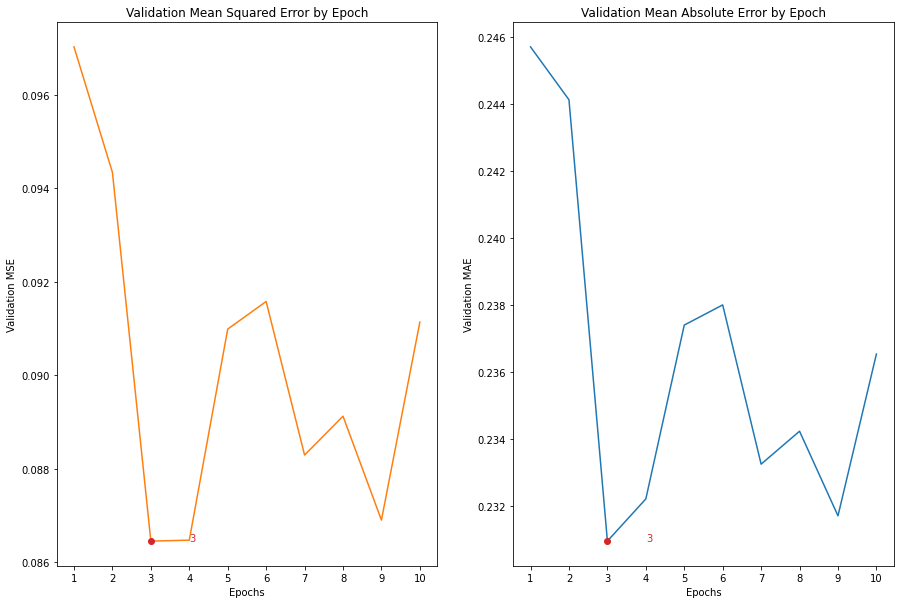

In [26]:
# plot optimal epochs for our simple model
results_seq = optimal_epochs(hist_seq, y_annotate_offset=0.000)

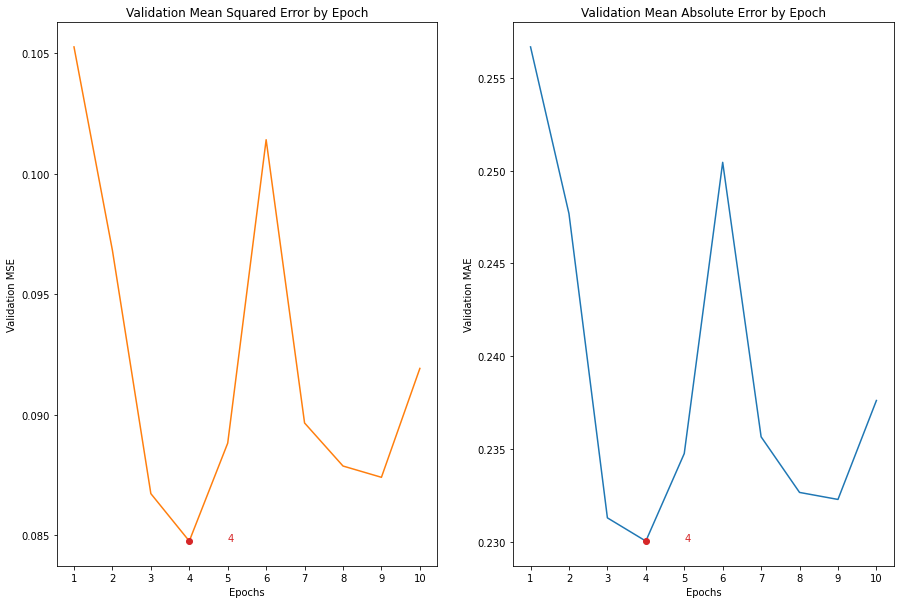

In [27]:
results_multi = optimal_epochs(hist_multi, y_annotate_offset=0.000)

In [28]:
# retrain with optimal epochs and regularization

OPTIMAL_SEQ = 3
OPTIMAL_MULTI = 4

best_sequential = LstmHyperModel(title_vectorizer, 
                                 sentence_vectorizer, 
                                 "sequential",
                                 sentence_embed,
                                 sentence_regularizer=regularizers.l2(0.01))

best_multi = LstmHyperModel(title_vectorizer, 
                            sentence_vectorizer, 
                            "multi_input",
                            sentence_embed,
                            title_embed,
                            sentence_regularizer=regularizers.l2(0.01),
                            title_regularizer=regularizers.l2(0.01))


best_sequential = best_sequential.build(best_hp_seq)
best_multi = best_multi.build(best_hp_multi)

final_seq = best_sequential.fit(multi_input_train_data, 
                                train_targets,
                                validation_split=0.15,
                                initial_epoch=0,
                                epochs=OPTIMAL_SEQ,
                                workers=8,
                                use_multiprocessing=True,
                                verbose=0)

final_multi = best_multi.fit(multi_input_train_data, 
                             train_targets,
                             validation_split=0.15,
                             initial_epoch=0,
                             epochs=OPTIMAL_MULTI,
                             workers=8,
                             use_multiprocessing=True,
                             verbose=0)

<a id='Evaluation'></a>
### Test Set Evaluation
[Back to top](#Top)

*We evaluate performance on the test set using the regularized models. In addition to Mean Squared Error, we investigate how our models' predictions would perform in a real-life implementation by using predicted helpfulness scores to rank sentence usefulness by product. We then compare the predicted rank to actual rank considering only the top 50 sentences for each product using Kendal's Tau measure (Kendall, 1938).*

In [34]:
# convenience label for multi-input test data
multi_input_test_data = {"sentence input": test_data["sentence"],
                         "title input": test_data["product_title"]}

# model evaluation

seq_eval = best_sequential.evaluate(multi_input_test_data, test_targets)
multi_eval = best_multi.evaluate(multi_input_test_data, test_targets)

print(f"Baseline: {base_mse, base_mae}\nSimple model: {basic_scores}\nSequential Model: {seq_eval}\nMulti-Input Model: {multi_eval}")

63/63 [==============================] - 3s 47ms/step - loss: 0.0864 - mae: 0.2281
Baseline: (0.1228345677771492, 0.28386842471037527)
Simple model: [0.08908335864543915, 0.23480592668056488]
Sequential Model: [0.08550546318292618, 0.2251134067773819]
Multi-Input Model: [0.08635150641202927, 0.2281370460987091]


<a id='Rank'></a>
### Ranking Performance
[Back to top](#Top)

*In order to better represent realistic performance for our models, we will evaluate their ability to identify only the top 30 most useful sentences by product. To achieve this, we will append our test data with a rank based on actual and predicted usefulness scores, then use a Kendall's Tau calculation to assess the degree of agreement.*

In [35]:
def evaluate_rankings(predict: pd.DataFrame) -> float:
    
    # create descending ranks from actual and predicted helfulness
    predict["predict_rank"] = predict.groupby("asin")["prediction"].rank(ascending=False, method="min")
    predict["actual_rank"] = predict.groupby("asin")["helpful"].rank(ascending=False, method="min")
    
    taus_top = []
    taus_other = []
    
    for product in predict["asin"].unique():
        top_by_product = predict[(predict["asin"] == product) & (predict["actual_rank"] <= 30)]
        other_by_product = predict[(predict["asin"] == product) & (predict["actual_rank"] > 30)]
        
        tau_top, p_top =  stats.kendalltau(top_by_product["predict_rank"], top_by_product["actual_rank"])
        tau_other, p_other = stats.kendalltau(other_by_product["predict_rank"], other_by_product["actual_rank"])
        
        taus_top.append((tau_top, p_top, top_by_product["predict_rank"], top_by_product["actual_rank"]))
        taus_other.append((tau_other, p_other))
    
    return taus_top, taus_other

In [49]:
# make predictions from test data for simple and tuned models
pred_simple = basic_model.predict(test_data["sentence"])
pred_sequential = best_sequential.predict(multi_input_test_data)
pred_multi = best_multi.predict(multi_input_test_data)

# baseline ranking scores
test_by_category["prediction"] = base_prediction
t_top_base, t_other_base = evaluate_rankings(test_by_category)

# simple model ranking scores
test_by_category["prediction"] = pred_simple
t_top_simp, t_other_simp = evaluate_rankings(test_by_category)

# single-input ranking performance
test_by_category["prediction"] = pred_sequential
t_top_sequential, t_other_sequential = evaluate_rankings(test_by_category)

# multi-input ranking performance
test_by_category["prediction"] = pred_multi
t_top_multi, t_other_multi = evaluate_rankings(test_by_category)

In [50]:
ranking_evaluation_models = [t_top_base, t_top_simp, t_top_sequential, t_top_multi]

In [56]:
"""evaluate and print results, showing average tau score, minimum tau score, 
and the predicted and actual ranks of the lowest score"""

for model in ranking_evaluation_models:
    tau_score = [t[0] for t in model]
    lowest = min(tau_score)
    print(np.mean(tau_score), min(tau_score))

0.32341223461157453 -1.0
0.49040219970436444 -0.6190476190476191
0.5224639703175049 -0.14285714285714288
0.5378975278019759 -0.04761904761904762


<a id='Conclusions'></a>
### Conclusions
[Back to top](#Top)

#### Conclusions

Model performance metrics are summarized below. Kendall's Tau values range from -1 to 1, corresponding to complete disagreement and complete agreement:

Model | Test Loss | Test MAE | Avg $\tau$ | Min $\tau$
:- | :-: | :-: | :-: | :-:
Baseline        |   0.123   |  0.284    |  0.323    | -1.0 |
Simple model    |   0.089   |  0.235    |   0.490   | -0.69 |
Best sequential |   0.086   |  0.23     | 0.522     | -0.143 |
Best multi-input|   0.086   |  0.228    |  0.538    | -0.048 |

While it was hypothesized that a model incorporating product titles information would perform better than one which did not, this difference is not pronounced when measured using traditional model performance metrics. When considering the final task of a model like this however, our multi-input model displays the most ability to accurately discern highly relevant sentences by product. With a minimum tau metric closest to zero, it is the least prone to problematic error, such that with products for which its predictions lead to poor rankings due to error, a direct comparison shows significantly less disagreement than other approaches.


#### Limitations and Further Investigation

Limitations of this investigation include assumptions made in hypermodel definition. Gamzu, et. al. report a lower test loss using Bert language embedding than achieved here with GloVe-based pre-trained embeddings. Additionally, some layer architectures were not explored here because of limitations with computational resources. Recurrent dropout in LSTM layers, for example, was not considered as it does not support GPU optimized training in the version of tensorflow used to implement this analysis (2.8). It is also probable that a higher number of experimental trials would produce higher performing hyperparameters using the Bayesian optimizer search, and possible that other types of search, such as [Hyperband](http://jmlr.org/papers/v18/16-558.html) (Li, et. al. 2018), might find better solutions in fewer trials.

Other than utilizing more state-of-the-art language embedding and/or networks with more depth, data on distinct product categories would allow for using a weighted loss function wherein the title branch would be scored separately and proportionately as a separate classification problem, allowing for greater control over the nature and significance of the title branch weights. More generally, however, this problem is presented here and in Gamzu, et. al. as a regression task where a network is directed to learn weights to approximate a continuous scale as closely as possible, though the nature of the end product resembling a kind of top-sentence ranking exercise suggests it may be interesting to recast labels to allow for classification with a [metric learning](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/contrib/losses/metric_learning) loss function. In addition to allowing for a model that would be capable of rejecting all sentence samples for a product if all were feasibly unhelpful (possibly valuable for products with a small amount of low-quality review data), this might allow for modeling that is more performant in end-use products, and might also facilitate a network more able to learn weights generalized by image data to contextualize review sentences instead of product titles. It is possible that product images might be less noisy, particularly if there are platform-enforced constraints on appropriate product image characteristics (e.g. types of backgrounds), if image segmentation and masking as preprocessing could reliably isolate products, and/or if transfer learning from an image to product category classifier were utilized. Another advantage of this approach could be that the context branch of a multi-input model using image data would theoretically be largely resilient to and reusable across review sentences and product titles in different languages.

<a id='References'></a>
### References
[Back to top](#Top)

Chollet, F. (2017). Deep learning with python. New York: Manning Publications Co. LLC. Retrieved from http://ebookcentral.proquest.com/lib/londonww/detail.action?docID=6642860

Maurice G. Kendall, “A New Measure of Rank Correlation”, Biometrika Vol. 30, No. 1/2, pp. 81-93, 1938.

O'Malley, T., Bursztein, E., Long, J., Chollet, F., Jin, H., Invernizzi, L., & others. (2019). KerasTuner. https://github.com/keras-team/keras-tuner. 

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

Porter, M. “An algorithm for suffix stripping.” Program 14.3 (1980): 130-137.

Gamzu, I., Gonen, H., Kutiel, G., Levy, R., & Agichtein, E. (2021). Identifying helpful sentences in product reviews Association for Computational Linguistics. doi:10.18653/v1/2021.naacl-main.55

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

Li, Lisha, and Kevin Jamieson. "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization." Journal of Machine Learning Research 18 (2018): 1-52.

Helpful Sentences from Reviews was accessed on 01-12-2021 from https://registry.opendata.aws/helpful-sentences-from-reviews.

<a id='Appendix'></a>
### Appendix
[Back to top](#Top)

*Appendix includes code snippets that may be useful for reproducing results in other contexts. Code to generate Directed acyclic graphs of model architecture depends on running most of the notebook before evaluation steps.*

Included items:

+ Glove Embeddings download
+ AWS CLI Download
+ Data download with AWS CLI
+ Additional Dependencies for Google Colab
+ Code to generate DAG images

In [ ]:
# get glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
# AWS CLI install for x86 linux 
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip awscliv2.zip
!sudo ./aws/install

In [ ]:
# recreate our dir structure
try:
    os.mkdir("data")
    
except FileExistsError:
    print("Data directory already exists")

# download data (requires aws CLI)
!aws s3 cp s3://helpful-sentences-from-reviews/train.json data/ --no-sign-request
!aws s3 cp s3://helpful-sentences-from-reviews/test.json data/ --no-sign-request

In [ ]:
# additional deps for colab
!pip install jsonlines keras-tuner

In [ ]:
%%capture

# graph visualisation code - this assumes 

# instantialte a LstmHyperModel and build with defaults to generate a directed acyclic graph image
default_model = LstmHyperModel(title_vectorizer, sentence_vectorizer, "multi_input")
hp = kt.HyperParameters()
model = default_model.build(hp)
tf.keras.utils.plot_model(model, "multi_input_model.png", show_layer_names=False)

default_model = LstmHyperModel(title_vectorizer, sentence_vectorizer, "sequential")
hp = kt.HyperParameters()
model = default_model.build(hp)
tf.keras.utils.plot_model(model, "sequential_model.png", show_layer_names=False)

# additionally graph our basic network
tf.keras.utils.plot_model(basic_model, "basic_model.png", show_layer_names=False)

# best sequential and multi-input graphs
tf.keras.utils.plot_model(best_sequential, "seq_model.png", show_shapes=False,
    show_dtype=True,
    show_layer_names=True,)
tf.keras.utils.plot_model(best_multi, "multi_model.png", show_layer_names=False)